# Experiments with combining spectra

<>:57: SyntaxWarning: invalid escape sequence '\D'
<>:57: SyntaxWarning: invalid escape sequence '\D'
/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_39869/2271825608.py:57: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title(prefix + "; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))


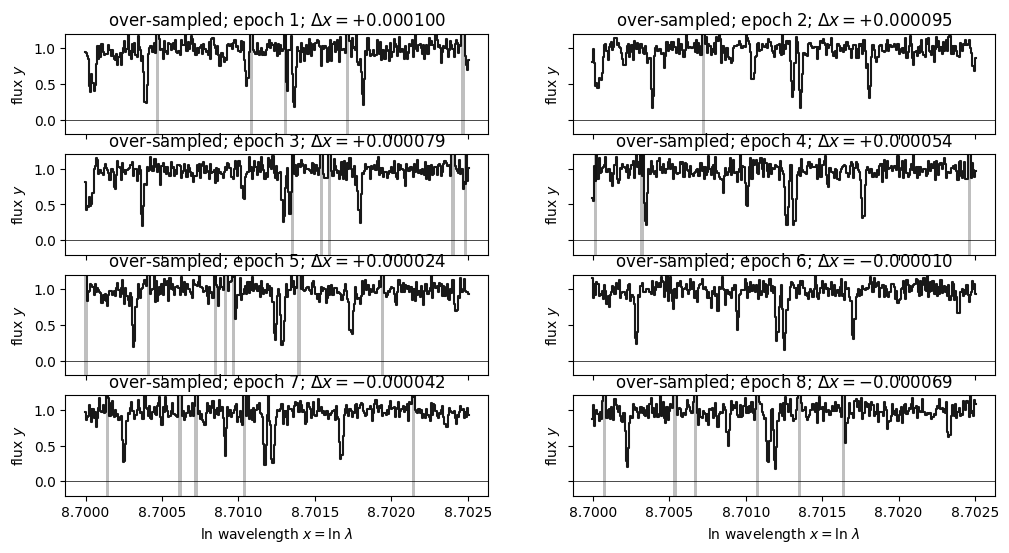

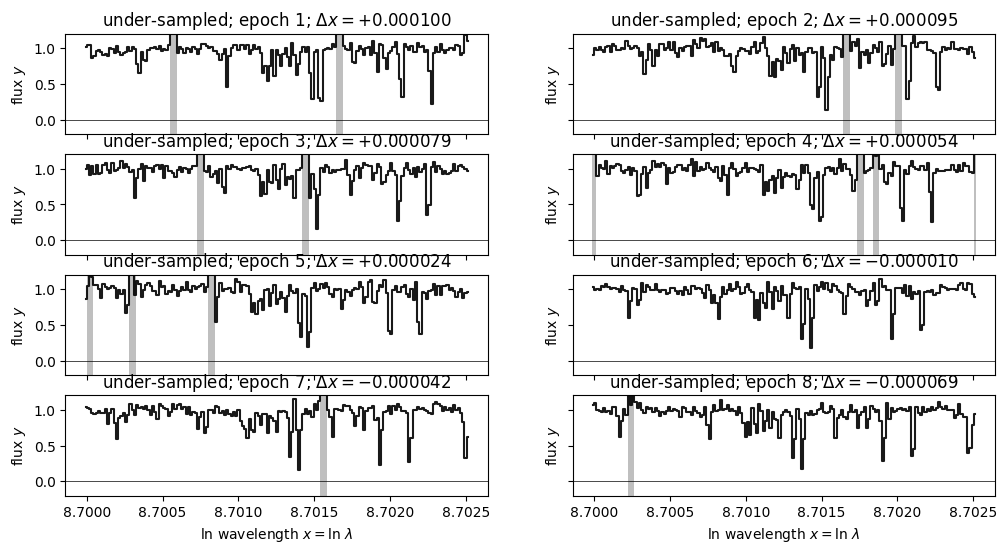

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from generate_data import make_one_dataset, true_spectrum
from frizzle import frizzle

R = 1.35e5

x_min = 8.7000
x_max = 8.7025

dxstar = 1. / R # output pixel grid spacing
xstar = np.arange(x_min + 1 * dxstar, x_max, dxstar)
if xstar.size % 2 == 0:
    xstar = xstar[:-1]  # make sure odd number of points for symmetry

dx_os = 1 / R
snr_os = 12

dx_us = 2 / R
snr_us = 18

P = np.round((x_max - x_min) * R).astype(int) # number of Fourier modes (ish)

dataset_kwds = dict(x_min=x_min, x_max=x_max)

# under-sampled case
xs_us, ys_us, ivars_us, bs_us, delta_xs_us, line_args_us = data_us = make_one_dataset(
    dx=dx_us, snr=snr_us, random_seed=17, **dataset_kwds
)

# over-sampled case
xs_os, ys_os, ivars_os, bs_os, delta_xs_os, line_args_os = data_os = make_one_dataset(
    dx=dx_os, snr=snr_os, random_seed=None, **dataset_kwds
)

def prepare_dataset(xs, ys, ivars, bs, delta_xs):
    xs = np.hstack([xs - dx for dx in delta_xs])
    ys = np.hstack(ys)
    ivars = np.hstack(ivars)
    mask = ~np.hstack(bs).astype(bool)
    return dict(λ=xs, flux=ys, ivar=ivars, mask=mask)

# show the input data
for xs, ys, ivars, bs, Delta_xs, line_args, prefix, pfn \
        in [(*data_os, "over-sampled", "data1.pdf"),
            (*data_us, "under-sampled", "data2.pdf")]:
    
    N = len(ys)
    dx = np.diff(xs).mean()
    fig, axes = plt.subplots(N // 2, 2, sharex=True, sharey=True,
                         figsize=(12., 0.75 * N))
    for j,ax in enumerate(axes.flatten()):
        ax.axhline(0., color="k", lw=0.5)
        ax.step(xs, ys[j], color="k", where="mid", alpha=0.9)
        ax.set_title(prefix + "; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))
        ax.set_ylabel(r"flux $y$")
        for k in np.arange(len(ys[j]))[bs[j] < 0.5]:
            ax.fill_between([xs[k] - 0.5 * dx, xs[k] + 0.5 * dx],
                            [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")
    for j in range(2):
        axes[-1, j].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
    ylim = (-0.2, 1.2)
    plt.ylim(*ylim)
    plt.savefig(pfn)

<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_39869/516776541.py:21: SyntaxWarning: invalid escape sequence '\D'
  axes[0].set_title("; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))


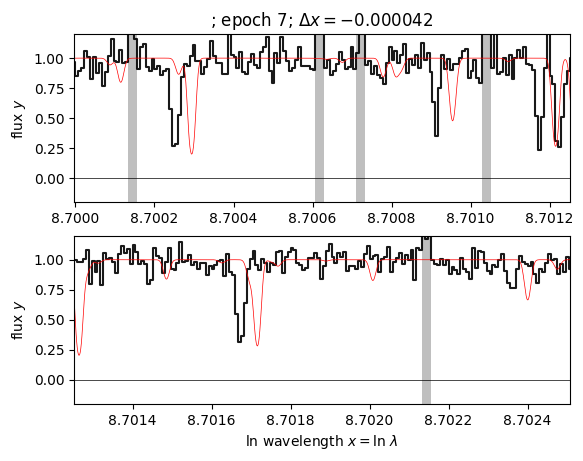

In [2]:

x_min, x_max = xs_os.min(), xs_os.max()
dx_os = np.diff(xs_os).mean()
# zoom in on one epoch and compare it to the true template.
j = 6
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
finexs = np.arange(x_min - 1. / R, x_max + 1. / R, 1. / (5. * R))
for ax in axes:
    ax.axhline(0., color="k", lw=0.5)
    ax.step(xs_os, ys_os[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0, *line_args_os), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
    for k in np.arange(len(ys_os[j]))[bs_os[j] < 0.5]:
        ax.fill_between([xs_os[k] - 0.5 * dx_os, xs_os[k] + 0.5 * dx_os],
                        [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")

axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))
plt.savefig("datazoom.pdf")

In [3]:

os_data = prepare_dataset(xs_os, ys_os, ivars_os, bs_os, delta_xs_os)

ystar_os, ivar_os, flags_os, meta_os = frizzle(xstar, **os_data)


In [4]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [5]:
ystar_os, ivar_os, flags_os, meta_os = frizzle(
    xstar,
    np.hstack([xs_os - delta_xs for delta_xs in delta_xs_os]),
    np.hstack(ys_os),
    np.hstack(ivars_os),
    ~np.hstack(bs_os).astype(bool)
)
ystar_us, ivar_us, flags_us, meta_us = frizzle(
    xstar,
    np.hstack([xs_us - delta_xs for delta_xs in delta_xs_us]),
    np.hstack(ys_us),
    np.hstack(ivars_us),
    ~np.hstack(bs_us).astype(bool),
)


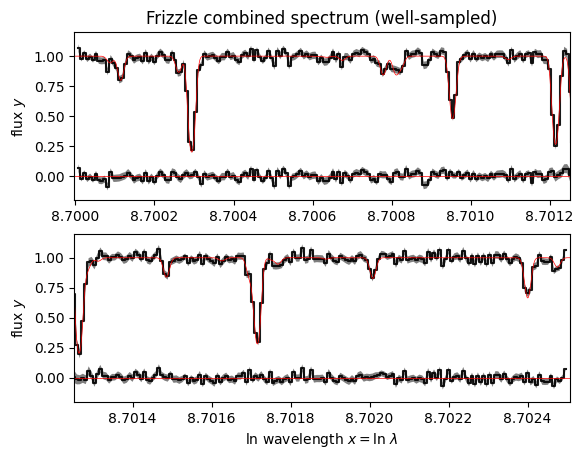

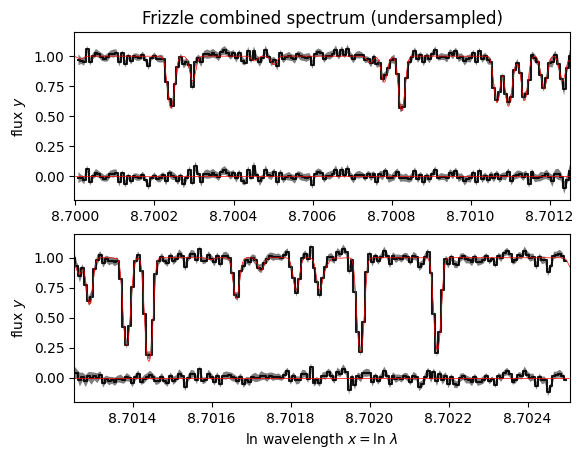

In [6]:
# compare the combined spectrum to the true template.
for ystar, ivar, line_args, name, pfn in [(ystar_os, ivar_os, line_args_os, "well-sampled", "forward1.pdf"),
                                          (ystar_us, ivar_us, line_args_us, "undersampled", "forward2.pdf")]:
    fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
    for ax in axes:
        ax.step(xstar, ystar, color="k", where="mid", alpha=0.9)
        ax.fill_between(xstar, ystar - ivar**-0.5, ystar + ivar**-0.5, color="k", alpha=0.5, ec="none")
        residual = ystar - true_spectrum(xstar, 0., *line_args)
        ax.step(xstar, residual, color="k", where="mid", alpha=0.9)
        ax.fill_between(xstar, residual - ivar**-0.5, residual + ivar**-0.5, color="k", alpha=0.5, ec="none")
        
        ax.set_ylabel(r"flux $y$")
        ax.plot(finexs, true_spectrum(finexs, 0., *line_args), "r-", lw=0.5)
        ax.axhline(0., color="r", lw=0.5)
        ax.ticklabel_format(useOffset=False)
    axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
    axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
    axes[0].set_ylim(*ylim)
    axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
    axes[0].set_title(f"Frizzle combined spectrum ({name})")
    plt.savefig(pfn)

In [7]:
raise a

NameError: name 'a' is not defined

In [ ]:
def Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar, kind="cubic"):
    #interpolate the data and the masks; deal with edges.
    # Note that we are being very conservative with the mask.
    N = len(ys)
    yprimes = np.zeros((N, len(xstar)))
    bprimes = np.zeros_like(yprimes).astype(int)
    ikwargs = {"kind": kind, "fill_value": "extrapolate"}
    for j in range(N):
        yprimes[j] = interp.interp1d(xs - Delta_xs[j], ys[j],
                                     **ikwargs)(xstar)
        bprimes[j] = (np.abs(interp.interp1d(xs - Delta_xs[j], bs[j],
                                     **ikwargs)(xstar) - 1.) < 0.03).astype(int)
        bprimes[j][xstar < (min(xs) - Delta_xs[j])] = 0
        bprimes[j][xstar > (max(xs) - Delta_xs[j])] = 0
    ystar = np.sum(yprimes * bprimes, axis=0) / np.sum(bprimes, axis=0)
    return ystar, yprimes, bprimes

# do the combination
ystar_sp_os, yprimes_os, bprimes_os = Standard_Practice_tm(xs_os, ys_os, bs_os, delta_xs_os, xstar)
ystar_sp_us, yprimes_us, bprimes_us = Standard_Practice_tm(xs_us, ys_us, bs_us, delta_xs_us, xstar)

Text(0.5, 1.0, 'over-sampled; epoch 7, interpolated to rest frame')

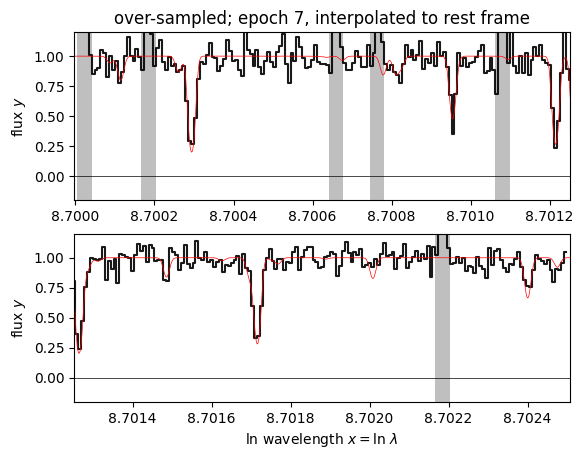

In [ ]:
j = 6
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
for ax in axes:
    ax.axhline(0., color="k", lw=0.5)
    ax.step(xstar, yprimes_os[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0., *line_args_os), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
    for k in np.arange(len(yprimes_os[j]))[bprimes_os[j] < 0.5]:
        ax.fill_between([xstar[k] - 0.5 * dxstar, xstar[k] + 0.5 * dxstar],
                        [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")
axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("over-sampled; epoch {}, interpolated to rest frame".format(j + 1))


In [ ]:
# Estimate covariances from just one trial:
def covariances(resids):
    lags = np.arange(12)
    var = np.zeros(len(lags)) + np.nan
    # sometimes standard practice can give nans when there are no data
    var[0] = np.nanmean(resids * resids)
    for lag in lags[1:]:
        var[lag] = np.nanmean(resids[lag:] * resids[:-lag])
    return lags, var



def estimate_frizzle_lag(n_trials, xstar, **dataset_kwds):
    numerator = 0
    for trial in range(n_trials):
        xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(**dataset_kwds)
        ystar, C_inv_star, *_ = frizzle(
            xstar,
            np.hstack([xs - delta_xs for delta_xs in Delta_xs]),
            np.hstack(ys),
            np.hstack(y_ivars),
            ~np.hstack(bs).astype(bool),
        )
        
        diff = (ystar - true_spectrum(xstar, 0., *line_args)) 
        lags, covars = covariances(diff)
        numerator += covars
    return (lags, numerator / n_trials)


def estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds, **dataset_kwds):
    if standard_practice_kwds is None:
        standard_practice_kwds = {}
    numerator = 0
    for trial in range(n_trials):
        xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(**dataset_kwds)
        ystar_sp, foo, bar = Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar, **standard_practice_kwds)        
        lags, covars = covariances(ystar_sp - true_spectrum(xstar, 0., *line_args))
        numerator += covars
    return (lags, numerator / n_trials)



def plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials):
    frizzle_name = "Frizzle"
    standard_name = "Standard Practice"

    name1 = "over-sampled"
    name2 = "under-sampled"

    fig, ax = plt.subplots()
    ax.axhline(0., color="k", lw=0.5)
    ax.plot(lags, covars_frizzle_os, "ko", ms=5,
            label=frizzle_name + ", " + name1)
    ax.plot(lags, covars_sp_os, "ko", ms=5, mfc="none",
            label=standard_name + ", " + name1)
    if covars_frizzle_us is not None:
        ax.plot(lags, covars_frizzle_us, "ko", ms=10, alpha=0.5, mec="none",
                label=frizzle_name + ", " + name2)
    if covars_sp_us is not None:
        ax.plot(lags, covars_sp_us, "ko", ms=10, alpha=0.5, mfc="none",
                label=standard_name + ", " + name2)
    ax.legend()
    ax.set_xlabel("lag (in output pixels)")
    ax.set_ylabel("covariance (squared-flux units)")
    ax.set_title("covariances estimated from {} trials".format(n_trials))
    fig.tight_layout()
    return fig



In [ ]:
np.random.seed(42)

n_trials = 64
lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, dx=dx_os, snr=snr_os, **dataset_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, dx=dx_us, snr=snr_us, **dataset_kwds)

lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, dx=dx_os, snr=snr_os, **dataset_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, dx=dx_us, snr=snr_us, **dataset_kwds)
fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)

KeyboardInterrupt: 

Satisfied that the results are largely the same, I will now use the newer implementation of frizzle for the rest of the notebook.
    
Remember that the results will not be exactly the same because the Hogg implementation does not use the pixel uncertainties.

# Experiment 1: Use Lorentzian line profiles


(-0.2, 1.2)

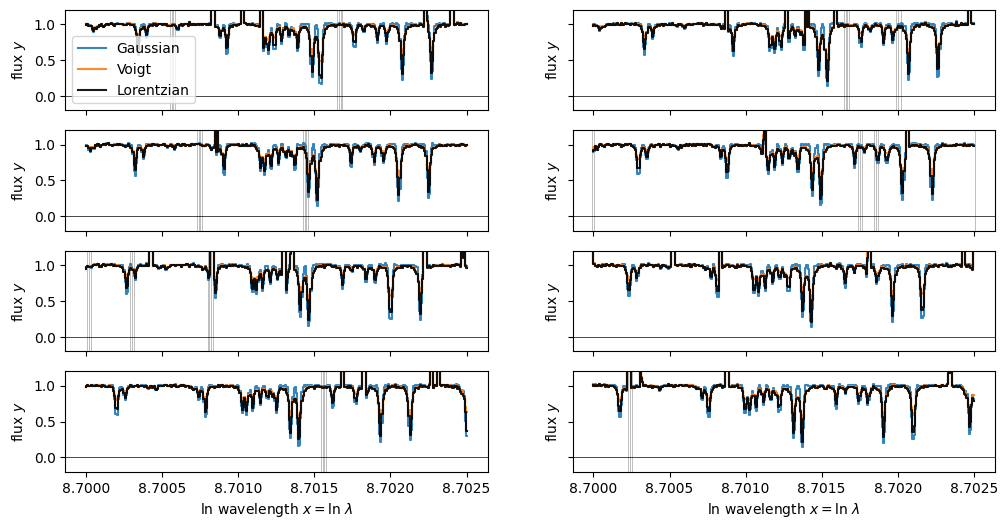

In [ ]:

xs_l, ys_l, ivars_l, bs_l, Delta_xs_l, line_args_l = make_one_dataset(
    dx=dx_os, snr=100, random_seed=17, profile_type="lorentzian", **dataset_kwds
)

xs_g, ys_g, ivars_g, bs_g, Delta_xs_g, line_args_g = make_one_dataset(
    dx=dx_os, snr=100, random_seed=17, profile_type="gaussian", **dataset_kwds
)
xs_v, ys_v, ivars_v, bs_v, Delta_xs_v, line_args_v = make_one_dataset(
    dx=dx_os, snr=100, random_seed=17, profile_type="voigt", **dataset_kwds
)

N = len(ys_l)
dx = np.diff(xs_l).mean()
fig, axes = plt.subplots(N // 2, 2, sharex=True, sharey=True,
                        figsize=(12., 0.75 * N))
for j,ax in enumerate(axes.flatten()):
    ax.axhline(0., color="k", lw=0.5)
    ax.step(xs_l, ys_g[j], color="tab:blue", where="mid", alpha=0.9, label="Gaussian")    
    ax.step(xs_l, ys_v[j], color="tab:orange", where="mid", alpha=0.9, label="Voigt")
    ax.step(xs_l, ys_l[j], color="k", where="mid", alpha=0.9, label="Lorentzian")
    ax.set_ylabel(r"flux $y$")
    for k in np.arange(len(ys[j]))[bs[j] < 0.5]:
        ax.fill_between([xs[k] - 0.5 * dx, xs[k] + 0.5 * dx],
                        [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")
for j in range(2):
    axes[-1, j].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")

axes[0,0].legend()
ylim = (-0.2, 1.2)
plt.ylim(*ylim)


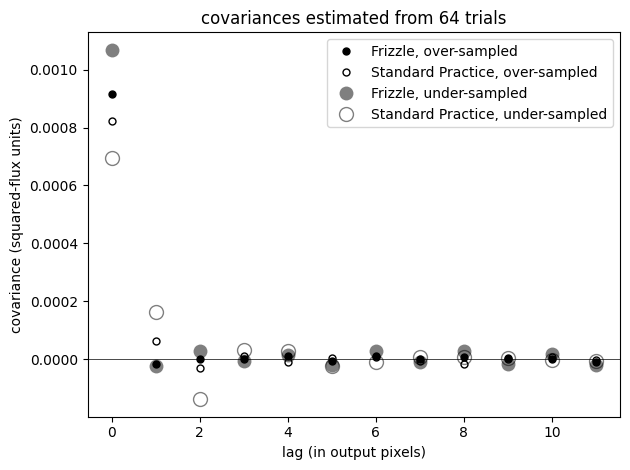

In [ ]:
np.random.seed(42)

os_kwds = dict(dx=dx_os, N=8, snr=snr_os, **dataset_kwds)
us_kwds = dict(dx=dx_us, N=8, snr=snr_us, **dataset_kwds)

profile_type = "lorentzian"

n_trials = 64
lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, profile_type=profile_type, **os_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, profile_type=profile_type, **us_kwds)

lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **os_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)

# Experiment 2: Use voigt profiles

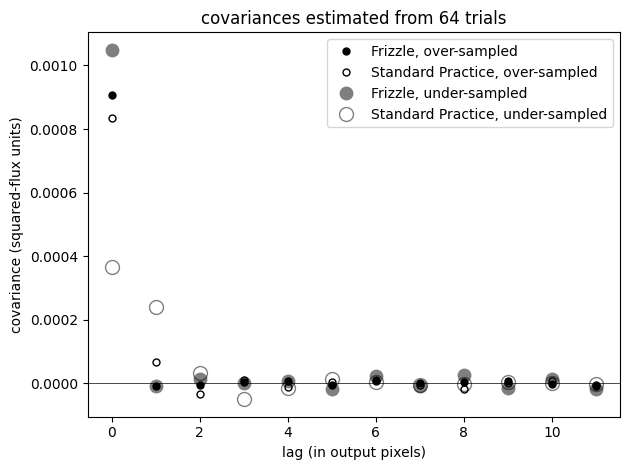

In [ ]:
n_trials = 64
profile_type = "voigt"

np.random.seed(42)

lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, profile_type=profile_type, **os_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, profile_type=profile_type, **us_kwds)

lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **os_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)


# Experiment 3: Include linear interpolation as a Standard Practice comparison


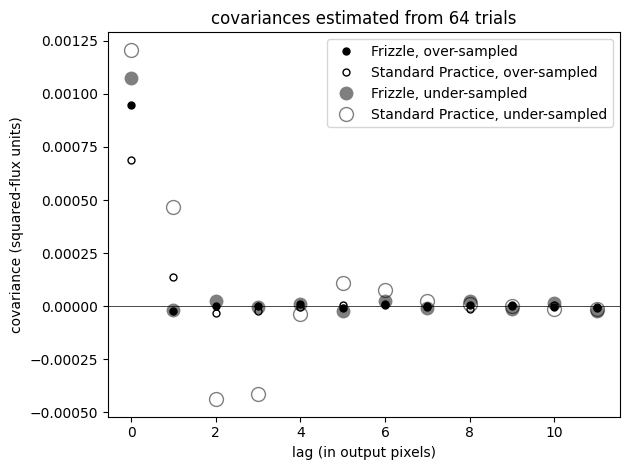

In [ ]:
profile_type = "gaussian"
standard_practice_kwds = dict(kind="linear")
n_trials = 64

np.random.seed(42)

lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, profile_type=profile_type, **os_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, profile_type=profile_type, **us_kwds)

lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, profile_type=profile_type, **os_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, profile_type=profile_type, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)


# Experiment 4: Single epoch resampling, from more pixels to fewer.

In [ ]:
# oversampled
xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(
    dx=dx_os, 
    snr=snr_os, 
    N=1, 
    random_seed=17, 
    profile_type="gaussian", 
    Delta_xs=np.array([0.5 * dx_os]),
    #badfrac=0.01,
    **dataset_kwds
)
print(dx_os * 0.5, Delta_xs)
xstar = np.linspace(xs[10], xs[-10], len(xs) - 30)
xi = np.hstack([xs - delta_xs for delta_xs in Delta_xs])
n_modes = int(np.sum(bs[0][(xstar[-1] > xi) * (xi > xstar[0])])) 
if n_modes % 2 == 0:
    n_modes -= 1

mask = ~np.hstack(bs).astype(bool)
from frizzle.utils import check_inputs
_, λ, flux, ivar, mask = check_inputs(xstar, xi, np.hstack(ys), np.hstack(y_ivars), mask)
print(n_modes, len(xstar), np.sum(~mask), (np.sum(~mask) / len(mask)) * len(xstar))
n_modes = int((np.sum(~mask) / len(mask)) * len(xstar))
ystar, ivar_star, *_, meta = frizzle(
    xstar, 
    λ,
    flux,
    ivar,
    mask,
    n_modes=n_modes,
    censor_missing_regions=False
)

finexs = np.arange(x_min - 1. / R, x_max + 1. / R, 1. / (5. * R))

fig, ax = plt.subplots(figsize=(15, 3))
ax.step(xs - Delta_xs[0], ys[0], color="k", where="mid", alpha=0.9)
ax.plot(finexs, true_spectrum(finexs, 0., *line_args), "tab:blue", label="true template")
ax.fill_between(xstar, ystar - ivar_star**-0.5, ystar + ivar_star**-0.5, color="k", alpha=0.5, ec="none")
ax.step(xstar, ystar, color="tab:red", where="mid", alpha=0.9, label="frizzled")
ax.set_ylim(0, 1.2)
ax.legend()

# Experiment 5: Single epoch resampling, going from P pixels to P different pixels.


In [ ]:
# oversampled
xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(
    dx=dx_os, 
    snr=snr_os, 
    N=1, 
    random_seed=17, 
    profile_type="gaussian", 
    Delta_xs=np.array([0.5 * dx_os]),
    badfrac=0.01,
    **dataset_kwds
)

ystar, ivar_star, *_, meta = frizzle(xs, xs - Delta_xs[0], ys, y_ivars, ~bs.astype(bool))

finexs = np.arange(x_min - 1. / R, x_max + 1. / R, 1. / (5. * R))

fig, ax = plt.subplots(figsize=(15, 3))
ax.step(xs - Delta_xs[0], ys[0], color="k", where="mid", alpha=0.9)
ax.plot(finexs, true_spectrum(finexs, 0., *line_args), "tab:blue", label="true template")
ax.fill_between(xstar, ystar - ivar_star**-0.5, ystar + ivar_star**-0.5, color="k", alpha=0.5, ec="none")
ax.step(xstar, ystar, color="tab:red", where="mid", alpha=0.9, label="frizzled")
ax.legend()

# Experiment 6: Multi-epoch data with near zero delta x variations


In [ ]:
N = 8

dxstar = 1. / R # output pixel grid spacing
xstar = np.arange(x_min + 1 * dxstar, x_max, dxstar)
if xstar.size % 2 == 0:
    xstar = xstar[:-1]  # make sure odd number of points for symmetry

small = 1e-6
xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(
    dx=dx_os, 
    snr=snr_os, 
    N=N, 
    random_seed=17, 
    profile_type="gaussian", 
    Delta_xs=np.random.uniform(low=-small, high=small, size=N),
    **dataset_kwds
)
ystar, *_, meta = frizzle(
    xstar, 
    np.hstack([xs - dxs for dxs in Delta_xs]),
    np.hstack(ys),
    np.hstack(y_ivars),
    ~np.hstack(bs).astype(bool),
)

finexs = np.arange(x_min - 1. / R, x_max + 1. / R, 1. / (5. * R))

fig, ax = plt.subplots(figsize=(15, 3))
ax.step(xs - Delta_xs[0], ys[0], color="k", where="mid", alpha=0.9)
ax.plot(finexs, true_spectrum(finexs, 0., *line_args), "tab:blue", label="true template")
ax.step(xstar, ystar, color="tab:red", where="mid", alpha=0.9, label="frizzled")
ax.set_ylim(0, 1.2)
ax.legend()

In [ ]:
profile_type = "gaussian"
standard_practice_kwds = dict(kind="cubic")

N = 8
small = 1e-6

n_trials = 64

np.random.seed(42)

os_kwds = dict(dx=dx_os, N=N, snr=snr_os, Delta_xs=np.random.uniform(low=-small, high=+small, size=N), **dataset_kwds)
us_kwds = dict(dx=dx_us, N=N, snr=snr_us, Delta_xs=np.random.uniform(low=-small, high=+small, size=N), **dataset_kwds)

lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, **os_kwds)
lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, **os_kwds)

lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, **us_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)


It is a problem if you are trying to `frizzle` under-sampled spectra with near zero `dx` offsets, AND you are trying to sample the output spectrum at a higher wavelength sampling.

In [ ]:

def _estimate_frizzle_lag(n_trials, xstar, frizzle_kwds, **dataset_kwds):
    numerator = 0
    for trial in range(n_trials):
        xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(**dataset_kwds)
        ystar, C_inv_star, *_ = frizzle(
            xstar,
            np.hstack([xs - delta_xs for delta_xs in Delta_xs]),
            np.hstack(ys),
            np.hstack(y_ivars),
            ~np.hstack(bs).astype(bool),
        )
        
        diff = (ystar - true_spectrum(xstar, 0., *line_args)) 
        lags, covars = covariances(diff)
        numerator += covars
    return (lags, numerator / n_trials)

profile_type = "gaussian"
standard_practice_kwds = dict(kind="cubic")

N = 8
small = 1e-6

n_trials = 64

np.random.seed(42)

os_kwds = dict(dx=dx_os, N=N, snr=snr_os, Delta_xs=np.random.uniform(low=-small, high=+small, size=N), **dataset_kwds)
us_kwds = dict(dx=dx_us, N=N, snr=snr_us, Delta_xs=np.random.uniform(low=-small, high=+small, size=N), **dataset_kwds)

#lags, covars_frizzle_os = _estimate_frizzle_lag(n_trials, xstar, dict(n_modes=xstar.size // 2), **os_kwds)
#lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, **os_kwds)

lags, covars_frizzle_us = _estimate_frizzle_lag(n_trials, xstar, dict(n_modes=xstar.size // 2), **us_kwds)
#lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)


# Experiment 7: Compute cost scaling

In [8]:

def Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar, ivars=None, kind="cubic"):
    #interpolate the data and the masks; deal with edges.
    # Note that we are being very conservative with the mask.
    N = len(ys)
    yprimes = np.zeros((N, len(xstar)))
    bprimes = np.zeros_like(yprimes).astype(int)
    yivars = np.zeros_like(yprimes)
    if ivars is None:
        ivars = np.ones_like(ys)
    ikwargs = {"kind": kind, "fill_value": "extrapolate"}
    for j in range(N):
        yprimes[j] = interp.interp1d(xs - Delta_xs[j], ys[j],
                                     **ikwargs)(xstar)
        bprimes[j] = (np.abs(interp.interp1d(xs - Delta_xs[j], bs[j],
                                     **ikwargs)(xstar) - 1.) < 0.03).astype(int)
        bprimes[j][xstar < (min(xs) - Delta_xs[j])] = 0
        bprimes[j][xstar > (max(xs) - Delta_xs[j])] = 0
        yivars[j] = interp.interp1d(xs - Delta_xs[j], ivars[j],
                                     **ikwargs)(xstar)
    
    ystar = np.sum(yprimes * bprimes, axis=0) / np.sum(bprimes, axis=0)
    yivars = np.sum(yivars * bprimes, axis=0) / np.sum(bprimes, axis=0)
    return ystar, yprimes, bprimes

def design_matrix(xs, P, L=(x_max - x_min)):
    """
    Take in a set of x positions and return the Fourier design matrix.

    ## Bugs:
    - Needs comment header.
    
    ## Comments:
    - The code looks different from the paper because Python zero-indexes.
    - This could be replaced with something that makes use of finufft.
    """
    X = np.ones_like(xs).reshape(len(xs), 1)
    for j in range(1, P):
        if j % 2 == 0:
            X = np.concatenate((X, np.cos(np.pi * j * xs / L)[:, None]), axis=1)
        else:
            X = np.concatenate((X, np.sin(np.pi * (j + 1) * xs / L)[:, None]), axis=1)
    return X

def pack_matrices(xs, ys, bs, Delta_xs, P):
    """
    Rearrange data into big matrices for `lstsq()`.

    ## Bugs:
    - Needs comment header.
    """
    XX = np.array([])
    YY = np.array([])
    for bb, yy, Dx in zip(bs, ys, Delta_xs):
        x_rest = (xs - Dx)[bb > 0.5]
        I = np.logical_and(x_rest > x_min, x_rest < x_max)
        YY = np.append(YY, yy[bb > 0.5][I])
        XX = np.append(XX, x_rest[I])
    return design_matrix(XX, P), YY

def Forward_Model_tm(xs, ys, bs, Delta_xs, P, xstar):
    """
    Do it all!
    
    ## Bugs:
    - Doesn't take the inverse variance on the data!
    - Doesn't return the inverse variance tensor for the output.
    """
    X, Y = pack_matrices(xs, ys, bs, Delta_xs, P)
    Xstar = design_matrix(xstar, P)
    thetahat, foo, bar, whatevs = np.linalg.lstsq(X, Y, rcond=None)
    return Xstar @ thetahat

In [ ]:
# as a function of number of epochs?
from time import time
from tqdm import tqdm

Ns = np.logspace(0, 3, 10).astype(int)
t_frizzle = []
t_cubic = []
t_linear = []

from frizzle.utils import check_inputs
from frizzle import _frizzle

n_trials = 3

P = len(xstar)

for N in tqdm(Ns):
    *args, line_args = make_one_dataset(dx=dx_os, snr=snr_os, N=N, random_seed=17, **dataset_kwds)
    xs, ys, ivars, bs, delta_xs = args
    frizzle_kwds = prepare_dataset(*args)

    # Time the true frizzle flops, because this outside part is the slowest and is not jitable yet
    λ_out, λ, flux, ivar, mask = check_inputs(λ_out=xstar, **frizzle_kwds)
    xstar, λ, flux, ivar = map(np.ascontiguousarray, (xstar, λ[~mask], flux[~mask], ivar[~mask]))

    xstar, λ, flux, ivar = map(jnp.asarray, (xstar, λ, flux, ivar))

    t_best = []
    for j in range(n_trials):
        t = time()
        _frizzle(xstar, λ, flux, ivar, len(xstar))[0].block_until_ready()
        t_best.append(time() - t)
    t_frizzle.append(np.min(t_best))

    t_best = []
    for j in range(n_trials):
        t = time()
        Standard_Practice_tm(xs, ys, bs, delta_xs, xstar)
        t_best.append(time() - t)
    t_cubic.append(np.min(t_best))

    t_best = []
    for j in range(n_trials):
        t = time()
        Standard_Practice_tm(xs, ys, bs, delta_xs, xstar, kind="linear")
        t_best.append(time() - t)
    t_linear.append(np.min(t_best))

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_39869/1355118192.py:21: RuntimeWarning: invalid value encountered in divide
  ystar = np.sum(yprimes * bprimes, axis=0) / np.sum(bprimes, axis=0)
/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_39869/1355118192.py:22: RuntimeWarning: invalid value encountered in divide
  yivars = np.sum(yivars * bprimes, axis=0) / np.sum(bprimes, axis=0)
 10%|█         | 1/10 [00:01<00:11,  1.30s/it]/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_39869/1355118192.py:21: RuntimeWarning: invalid value encountered in divide
  ystar = np.sum(yprimes * bprimes, axis=0) / np.sum(bprimes, axis=0)
/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_39869/1355118192.py:22: RuntimeWarning: invalid value encountered in divide
  yivars = np.sum(yivars * bprimes, axis=0) / np.sum(bprimes, axis=0)
 20%|██        | 2/10 [00:02<00:11,  1.38s/it]/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/i

In [ ]:
P = len(xstar)
t_hogg = []
for N in tqdm(Ns):
    *args, line_args = make_one_dataset(dx=dx_os, snr=snr_os, N=N, random_seed=17, **dataset_kwds)
    xs, ys, ivars, bs, delta_xs = args
    t_best = []
    for j in range(n_trials):
        t = time()
        Forward_Model_tm(xs, ys, bs, delta_xs, P, xstar)
        t_best.append(time() - t)
    t_hogg.append(np.min(t_best))


 75%|███████▌  | 15/20 [15:09<05:03, 60.61s/it] 


KeyboardInterrupt: 

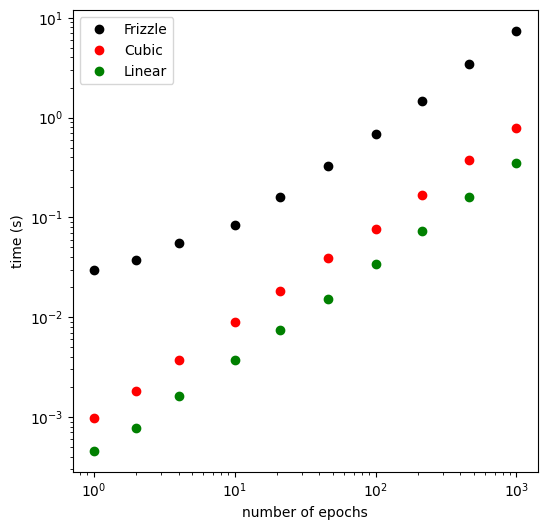

In [ ]:

t_cubic = np.array(t_cubic)
t_linear = np.array(t_linear)

fig, axes = plt.subplots(figsize=(6, 6))
#axes.plot(Ns[:len(t_hogg)], t_hogg, "bo", label="Frizzle (Hogg)")
axes.plot(Ns, t_frizzle, "ko", label="Frizzle")
axes.plot(Ns, t_cubic, "ro", label="Cubic")
axes.plot(Ns, t_linear, "go", label="Linear")
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlabel("number of epochs")
axes.set_ylabel("time (s)")
axes.legend()
#fig.savefig("frizzle_speed.pdf", dpi=300)

In [ ]:
# Let's do a bigger example
from time import time
from tqdm import tqdm

Ns = np.logspace(0, 2, 20).astype(int)
t_frizzle = []
t_cubic = []
t_linear = []

from frizzle.utils import check_inputs
from frizzle import _frizzle

n_trials = 10

# Gives approximate apogee-spectra
x_min = 8.7
x_max = 8.765
x_max = 8.7025

dxstar = 1. / R # output pixel grid spacing
xstar = np.arange(x_min + 1 * dxstar, x_max, dxstar)
if xstar.size % 2 == 0:
    xstar = xstar[:-1]  # make sure odd number of points for symmetry

dx = 1 / R
snr = 12

P = np.round((x_max - x_min) * R).astype(int) # number of Fourier modes (ish)

print(xstar.size)
cost_dataset_kwds = dict(x_min=x_min, x_max=x_max, dx=dx, snr=snr, R=R)


for N in tqdm(Ns):
    *args, line_args = make_one_dataset(N=N, **cost_dataset_kwds)
    xs, ys, ivars, bs, delta_xs = args
    frizzle_kwds = prepare_dataset(*args)

    # Time the true frizzle flops, because this outside part is the slowest and is not jitable yet
    λ_out, λ, flux, ivar, mask = check_inputs(λ_out=xstar, **frizzle_kwds)
    λ, flux, ivar = jnp.asarray(λ[~mask]), jnp.asarray(flux[~mask]), jnp.asarray(ivar[~mask])
    print("trialling")
    
    raise a
    t_best = []
    for j in range(n_trials):
        t = time()
        _frizzle(xstar, λ, flux, ivar, min(len(xstar), len(flux)), rtol=1e-6, atol=1e-6, rcond=None)[0].block_until_ready()
        t_best.append(time() - t)
    t_frizzle.append(np.min(t_best))

    """
    t_best = []
    for j in range(n_trials):
        t = time()
        Standard_Practice_tm(xs, ys, bs, delta_xs, xstar)
        t_best.append(time() - t)
    t_cubic.append(np.min(t_best))

    t_best = []
    for j in range(n_trials):
        t = time()
        Standard_Practice_tm(xs, ys, bs, delta_xs, xstar, kind="linear")
        t_best.append(time() - t)
    t_linear.append(np.min(t_best))
    """

337


  0%|          | 0/20 [00:00<?, ?it/s]

trialling


NameError: name 'a' is not defined

In [ ]:
_frizzle(xstar, λ, flux, ivar, min(len(xstar), len(flux)), rtol=1e-6, atol=1e-6, rcond=None)[0].block_until_ready()

Array([ 1.45423452e+09, -1.85620857e+06,  2.18245547e+05, -4.47592044e+04,
        1.22958580e+04, -4.08070350e+03,  1.55260916e+03, -6.53334163e+02,
        3.00394677e+02, -1.45643283e+02,  7.69710672e+01, -4.01880574e+01,
        2.43866456e+01, -1.28543912e+01,  9.14242362e+00, -4.13058382e+00,
        4.30512757e+00, -1.12565666e+00,  2.20287086e+00,  5.25711071e-02,
        1.71676601e+00,  5.20059313e-01,  1.38674578e+00,  6.34649172e-01,
        6.99919604e-01,  3.88329030e-01,  7.79845093e-01,  7.79283950e-01,
        9.53547694e-01,  3.58317558e-01,  4.26278103e-01,  5.69589194e-01,
        6.69592107e-01,  9.79549109e-01,  9.40982413e-01,  1.10687450e+00,
        9.92812615e-01,  9.50868828e-01,  8.34471741e-01,  7.87657396e-01,
        7.29554733e-01,  8.39304757e-01,  8.83248865e-01,  8.81329978e-01,
        9.71987717e-01,  8.54525030e-01,  6.88761218e-01,  5.05260160e-01,
        5.18807845e-01,  7.07540355e-01,  9.22981586e-01,  1.01622002e+00,
        8.97283041e-01,  

In [ ]:
%debulen(λ)